# TODO


* Check BF's and effect sizes using weaker/stronger priors (probably won't have any effect here, except maybe for max-d in mouse data with CoMs)
* Calculate BF's using ten independent fits (would take 10x time, only do when finalizing the paper submission)

Exploratory analyses
* Run exploratory analysis of trajectory entropy (Calcagni et al 2017, http://polorovereto.unitn.it/~antonio.calcagni/emot.html)
* Run decision landscapes (compare three tertiles of $\Delta$ (SS left, LL right), compare strong discounters to weak discounters, compare walking vs mouse, 1st task vs 2nd task) 

# Contents

* [Preregistered analysis](#prereg)
  * [Mouse-tracking task](#mouse) 
    * [Max-d](#mouse_max_d)
    * [Response time](#mouse_RT)
  * [Walking task](#walking) 
    * [Max-d](#walking_max_d)
    * [Response time](#walking_RT)
* [Effect of changes-of-mind](#com)
  * [Mouse-tracking task](#com_mouse)
  * [Walking task](#com_walking)
* [Exploratory analysis](#explore)

In [3]:
library(tmvtnorm)
library(ggplot2)
library(ggExtra)
library(brms)
library(reshape2)
library(coda)
library(mefa)
library(tidybayes)
library(ggstance)
library(viridis)
library(latex2exp)
library(ggthemes)
library(data.table)
library(bayesplot)
library(diptest)

# data_path = "../data/choices_processed.txt"
data_path = "C:/Users/Arkady/Google Drive/data/beyond_the_reach"
figure_path = "C:/Users/Arkady/Dropbox/Research/Journal papers/2018 Beyond the reach/figures"
table_path = "C:/Users/Arkady/Dropbox/Research/Journal papers/2018 Beyond the reach/tables"

figure_format = "png"

Loading required package: mvtnorm
Loading required package: Matrix
Loading required package: stats4
Loading required package: gmm
Loading required package: sandwich
Loading required package: Rcpp
Loading 'brms' package (version 2.4.0). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').
Run theme_set(theme_default()) to use the default bayesplot theme.
mefa 3.2-7 	 2016-01-11

Attaching package: 'mefa'

The following object is masked from 'package:reshape2':

    melt

NOTE: As of tidybayes version 1.0, several functions, arguments, and output column names
      have undergone significant name changes in order to adopt a unified naming scheme.
      See help('tidybayes-deprecated') for more information.


Attaching package: 'ggstance'

The following objects are masked from 'package:ggplot2':

    geom_errorbarh, GeomErrorbarh

Loading required package: viridisLite

Attaching package: 'data.

Load processed data

In [3]:
get_processed_data <- function(data_path){
    filename <- file.path(data_path, "choices_processed.txt")
    data <- read.table(filename, header = TRUE, sep = ",")
    data[, "subj_id"] <- as.factor(data[, "subj_id"])
    data[, "option_chosen"] <- as.factor(data[, "option_chosen"])
    
    return(data)
}

In [4]:
data <- get_processed_data(data_path)
mouse_data <- data[data$task=="mouse",]
walking_data <- data[data$task=="walking",]

# Checking for max-d unimodality<a class="anchor" id="com"></a>

Checking for unimodality of the max-d distributions

In [5]:
print(dip.test(mouse_data$max_d, simulate.p.value = TRUE))
print(dip.test(walking_data$max_d, simulate.p.value = TRUE))


	Hartigans' dip test for unimodality / multimodality with simulated
	p-value (based on 2000 replicates)

data:  mouse_data$max_d
D = 0.0052932, p-value = 0.965
alternative hypothesis: non-unimodal, i.e., at least bimodal


	Hartigans' dip test for unimodality / multimodality with simulated
	p-value (based on 2000 replicates)

data:  walking_data$max_d
D = 0.0061884, p-value = 0.855
alternative hypothesis: non-unimodal, i.e., at least bimodal



Hartigans' dip test doesn't provide evidence in favor of multimodality. Still, the histograms of max-d for the walking task reveal that there are at least two distinct clusters of trajectories. For this reason, we check the robustness of the max-d analysis using a subset of trajectories which exclude changes-of-mind (CoM; see preprocessing notebook for a criterion used to detect CoMs)

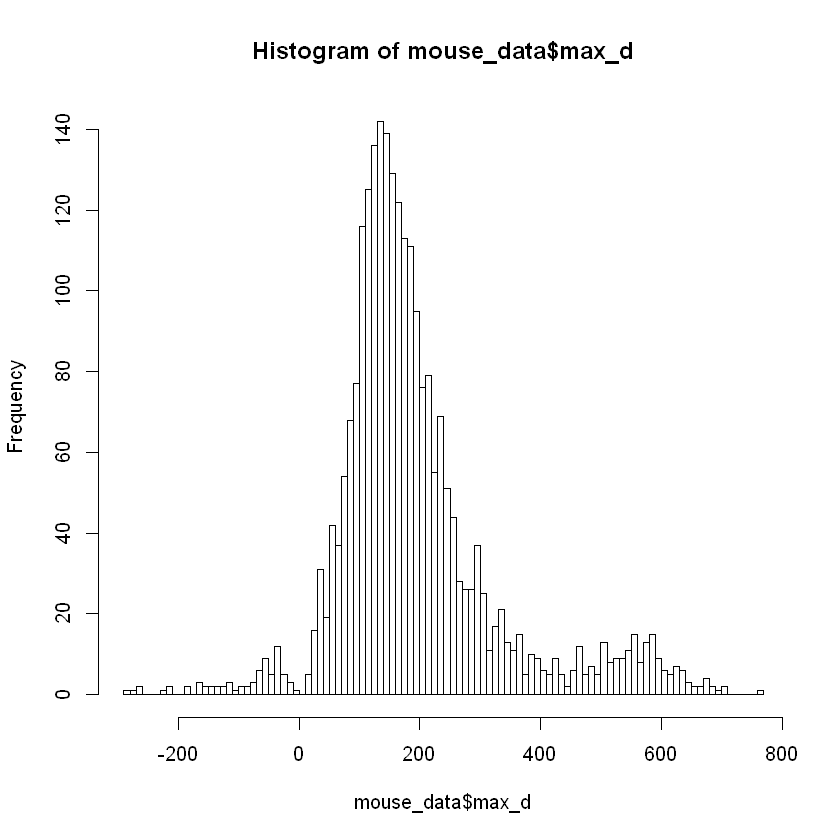

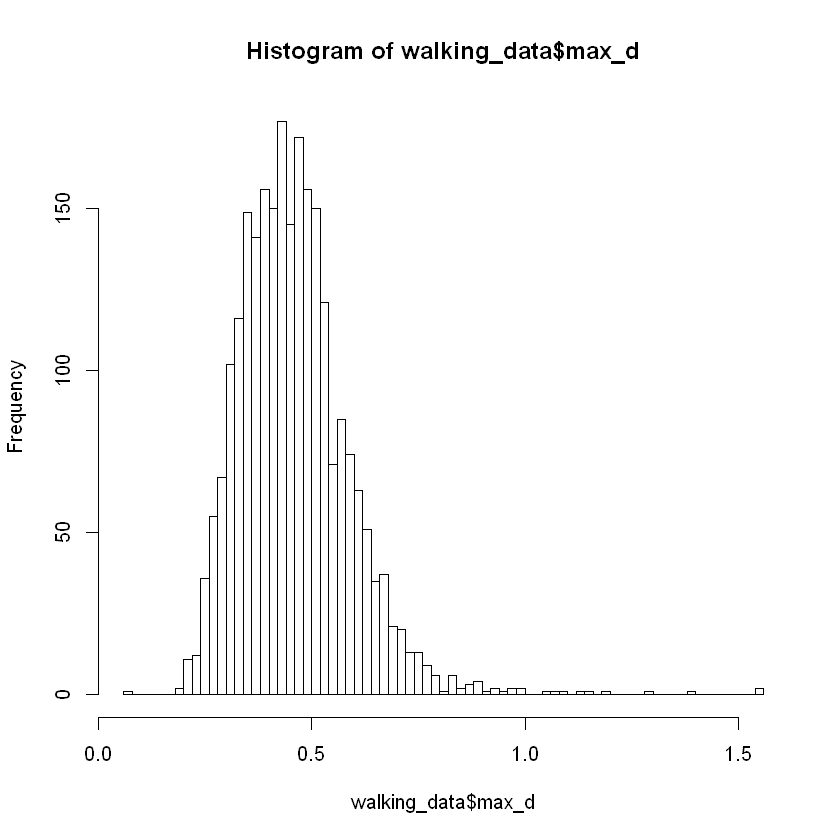

In [6]:
hist(mouse_data$max_d, breaks = 100, freq = TRUE)
hist(walking_data$max_d, breaks = 100, freq = TRUE)

In [7]:
mouse_data_no_com <- mouse_data[mouse_data$is_com=="False",]
walking_data_no_com <- walking_data[walking_data$is_com=="False",]

# Functions for model fitting and BF calculation

In [8]:
get_bf_dyn <- function(models, data, formulas, prior){ 
    " This function fits three models to the supplied data, and returns these models with pairwise BF's"
    m_inter <- fit_model(models$m_inter, data, formulas$f_inter, prior)
    m_choice <- fit_model(models$m_choice, data, formulas$f_choice, prior[1,])
    m_null <- fit_model(models$m_null, data, formulas$f_null, prior[1,])
    
    bf <- t(c(bayes_factor(x1 = m_choice, x2 = m_null)$bf,
              bayes_factor(x1 = m_inter, x2 = m_null)$bf,
              bayes_factor(x1 = m_inter, x2 = m_choice)$bf))
    ci_inter <- HPDinterval(as.mcmc(m_inter, combine_chains = TRUE))
    
    result = list(bf = bf, models = list(m_null = m_null, m_choice = m_choice, m_inter = m_inter), ci_inter = ci_inter)
    
    return(result)
}

fit_model <- function(model, data, formula, prior){
    " This function updates the brms model if it exists (to avoid slow recompilation of the C++ model by Stan), 
    or creates a model from scratch if it doesn't exist yet "
    if(!is.null(model)){
        model <- update(model, newdata = data, recompile = F)        
    } else {
        model <- brm(formula, data = data, family = gaussian(), save_all_pars = TRUE,
                   control = list(adapt_delta = 0.99), prior = prior, refresh = 0)
    }
    return(model)
}

run_analysis <- function(dv, iv, data, rscale){
    " This function runs our analysis for a given dataset (fake or real) and given dependent and 
    independent variables (dv and iv); rscale parameter defines the scale of prior distribution 
    on regression slopes (see Rouder & Morey (2012))"
    models <- list(m_inter = NULL, m_choice = NULL, m_null = NULL)

    " Priors on centered intercepts are the values of DV when all predictors are at their means (see brms docs).
    brms accepts priors on non-standardized b coefficients. We compute them by scaling default priors on standardized 
    coefficients (Rouder & Morey, 2012) to sd(DV)/sd(IV)"
    prior <- c(set_prior(sprintf('normal(%f, %f)', mean(data[, dv]), sd(data[, dv])), class = "Intercept"),
               set_prior(sprintf('cauchy(0, %f)', rscale*sd(data[, dv])/sd(data[, iv])), class = "b"))

    interaction_term = paste(iv, "option_chosen", sep=':')
    formulas <- list(f_inter = as.formula(paste(dv, "~ (option_chosen | subj_id) + option_chosen +", interaction_term)),
                     f_choice = as.formula(paste(dv, "~ (option_chosen | subj_id) + option_chosen")),
                     f_null = as.formula(paste(dv, "~ (1 | subj_id)")))

    bf_result <- get_bf_dyn(models, data, formulas, prior)
    
    analysis_id <- paste(dv, iv, deparse(substitute(data)))
    
    bf_result$analysis_id <- analysis_id    
    print_bf(bf_result, analysis_id, iv)
    
    return(bf_result)
}

# Functions for visualizing and saving the results

In [56]:
print_bf <- function(bf_result, iv="Delta"){
    print(bf_result$analysis_id)
    print(sprintf("BF of choice model over null model: %g", bf_result$bf[1]))
    print(sprintf("BF of choice-by-delta model over null model: %g", bf_result$bf[2]))
    print(sprintf("BF of choice-by-delta model over choice-only model: %g", bf_result$bf[3]))
    
    print(bf_result$ci[c(paste("b_option_chosenll:", iv, sep=""), 
                         paste("b_option_chosenss:", iv, sep=""),
                         "b_option_chosenss"),]) 
}

spaghetti_plot <- function(model, data, dv, iv, task, figure_format){
    file_name=sprintf("spaghetti_%s_%s.%s", task, dv, figure_format)
    plt <- plot(marginal_effects(model, spaghetti=TRUE, nsamples=300, 
                                 effects=paste(iv, "option_chosen", sep=":")), 
                plot=FALSE)[[1]]                                                                            
    plt <- plt + 
        geom_point(aes_string(x=iv, y=dv, shape='option_chosen', colour='option_chosen'), 
                   size = 3, alpha=0.1, data = data) +
        theme_pander(base_size = 24) +
        ggtitle(paste(task, gsub("_", "-", dv))) +
        theme(plot.title = element_text(hjust = 0.5, size=24, face="plain")) +
        xlab(TeX("$\\Delta$")) +
        ylab(gsub("_", "-", dv)) +
        theme(legend.position="none") +
        scale_color_viridis(discrete=TRUE, alpha=0.2, begin=0.0, end=0.7)
    if ((dv == 'RT') & (task == 'walking')){   
        plt <- plt + theme(legend.position = c(0.9, 0.9),
                      legend.title = element_blank(),
                      legend.text = element_text(size=24)) +
                guides(colour = guide_legend(override.aes=list(size = 8, linetype = 0, alpha = 1)))
    }
    ggsave(file.path(figure_path, file_name), dpi=300, width=4, height=4) 
}

save_posterior <- function(model, iv, file_name){    
    write.csv(as.matrix(as.mcmc(model, combine_chains=TRUE)), 
              file=file.path("posterior_csv", iv, file_name), row.names=FALSE)
}

visualize_result <- function(bf_result, data, task, dv, iv, figure_format){
    print_bf(bf_result, iv)
    spaghetti_plot(bf_result$models$m_inter, data, dv, iv, task, figure_format)
    save_posterior(bf_result$models$m_inter, iv, file_name = sprintf("posterior_%s_%s.%s", task, dv, "csv"))
}

# Functions for aggregating the results

In [54]:
save_all_plots <- function(results, iv){
    visualize_result(results$mouse_max_d_bf, mouse_data, "mouse", "max_d", iv, figure_format)
    visualize_result(results$mouse_rt_bf, mouse_data, "mouse", "RT", iv, figure_format)
    visualize_result(results$walking_max_d_bf, walking_data, "walking", "max_d", iv, figure_format)
    visualize_result(results$walking_rt_bf, walking_data, "walking", "RT", iv, figure_format)
    visualize_result(results$mouse_max_d_no_com_bf, mouse_data_no_com, 
                    "mouse_no_com", "max_d", iv, figure_format) 
    visualize_result(results$walking_max_d_no_com_bf, walking_data_no_com, 
                    "walking_no_com", "max_d", iv, figure_format)    
    visualize_result(results$walking_rt_no_com_bf, walking_data_no_com, 
                    "walking_no_com", "RT", iv, figure_format)    
    visualize_result(results$mouse_rt_no_com_bf, mouse_data_no_com, 
                    "mouse_no_com", "RT", iv, figure_format)
}

run_all_analyses <- function(iv, rscale){
    mouse_max_d_bf <- run_analysis("max_d", iv, mouse_data, rscale)
    mouse_rt_bf <- run_analysis("RT", iv, mouse_data, rscale)
    
    walking_max_d_bf <- run_analysis("max_d", iv, walking_data, rscale)
    walking_rt_bf <- run_analysis("RT", iv, walking_data, rscale)
    
    mouse_max_d_no_com_bf <- run_analysis("max_d", iv, mouse_data_no_com, rscale)        
    mouse_rt_no_com_bf <- run_analysis("RT", iv, mouse_data_no_com, rscale)    
    
    walking_max_d_no_com_bf <- run_analysis("max_d", iv, walking_data_no_com, rscale)
    walking_rt_no_com_bf <- run_analysis("RT", iv, walking_data_no_com, rscale)
        
    return(list(mouse_max_d_bf = mouse_max_d_bf, mouse_rt_bf = mouse_rt_bf, 
                walking_max_d_bf = walking_max_d_bf, walking_rt_bf = walking_rt_bf, 
                mouse_max_d_no_com_bf = mouse_max_d_no_com_bf, mouse_rt_no_com_bf = mouse_rt_no_com_bf,
                walking_max_d_no_com_bf = walking_max_d_no_com_bf, walking_rt_no_com_bf = walking_rt_no_com_bf))
}

# Run analyses (takes a lot of time!)

In [11]:
lambda_results <- run_all_analyses("Lambda", rscale=0.707)

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 20.25 seconds (Warm-up)
               11.785 seconds (Sampling)
               32.035 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 28.292 seconds (Warm-up)
               11.662 seconds (Sampling)
               39.954 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 26.215 seconds (Warm-up)
               12.242 seconds (Sampling)
               38.457 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 24.544 seconds (Warm-up)
               14.1 seconds (Sampling)
               38.644 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 20.896 seconds (Warm-up)
               13.848 seconds (Sampling)
               34.744 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 20.42 seconds (Warm-up)
               11.275 seconds (Sampling)
               31.695 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 25.

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.085 seconds (Warm-up)
               2.62 seconds (Sampling)
               7.705 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.699 seconds (Warm-up)
               4.567 seconds (Sampling)
               10.266 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.904 seconds (Warm-up)
               2.593 seconds (Sampling)
               7.497 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.854 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 26.588 seconds (Warm-up)
               20.308 seconds (Sampling)
               46.896 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 27.099 seconds (Warm-up)
               15.738 seconds (Sampling)
               42.837 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 29.42 seconds (Warm-up)
               20.981 seconds (Sampling)
               50.401 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 19.786 seconds (Warm-up)
               12.092 seconds (Sampling)
               31.878 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 22.422 seconds (Warm-up)
               16.269 seconds (Sampling)
               38.691 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 21.229 seconds (Warm-up)
               17.91 seconds (Sampling)
               39.139 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elaps

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.688 seconds (Warm-up)
               4.121 seconds (Sampling)
               8.809 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.054 seconds (Warm-up)
               4.293 seconds (Sampling)
               8.347 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.627 seconds (Warm-up)
               3.372 seconds (Sampling)
               7.999 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.338 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 34.906 seconds (Warm-up)
               21.807 seconds (Sampling)
               56.713 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 46.785 seconds (Warm-up)
               22.416 seconds (Sampling)
               69.201 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 36.587 seconds (Warm-up)
               13.542 seconds (Sampling)
               50.129 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed T

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 30.124 seconds (Warm-up)
               12.212 seconds (Sampling)
               42.336 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 27.891 seconds (Warm-up)
               19.09 seconds (Sampling)
               46.981 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 27.988 seconds (Warm-up)
               19.881 seconds (Sampling)
               47.869 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 30.039

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 6.741 seconds (Warm-up)
               3.624 seconds (Sampling)
               10.365 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.412 seconds (Warm-up)
               2.474 seconds (Sampling)
               9.886 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 8.037 seconds (Warm-up)
               3.998 seconds (Sampling)
               12.035 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.553 second

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 37.013 seconds (Warm-up)
               22.736 seconds (Sampling)
               59.749 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 35.94 seconds (Warm-up)
               24.331 seconds (Sampling)
               60.271 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 39.251 seconds (Warm-up)
               36.241 seconds (Sampling)
               75.492 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 39.239

Warning message:
"There were 6 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
http://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 29.976 seconds (Warm-up)
               21.042 seconds (Sampling)
               51.018 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 29.562 seconds (Warm-up)
               20.748 seconds (Sampling)
               50.31 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 33.953 seconds (Warm-up)
               21.533 seconds (Sampling)
               55.486 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.028 seconds (Warm-up)
               8.473 seconds (Sampling)
               13.501 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.473 seconds (Warm-up)
               3.899 seconds (Sampling)
               8.372 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.791 seconds (Warm-up)
               4.262 seconds (Sampling)
               9.053 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.635 se

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 27.658 seconds (Warm-up)
               11.028 seconds (Sampling)
               38.686 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 28.685 seconds (Warm-up)
               20.369 seconds (Sampling)
               49.054 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 26.111 seconds (Warm-up)
               13.225 seconds (Sampling)
               39.336 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elap

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 20.796 seconds (Warm-up)
               17.212 seconds (Sampling)
               38.008 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 20.927 seconds (Warm-up)
               14.5 seconds (Sampling)
               35.427 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 20.412 seconds (Warm-up)
               17.497 seconds (Sampling)
               37.909 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 24.391 

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.364 seconds (Warm-up)
               3.805 seconds (Sampling)
               9.169 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 6.459 seconds (Warm-up)
               3.833 seconds (Sampling)
               10.292 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.643 seconds (Warm-up)
               3.978 seconds (Sampling)
               9.621 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.163 se

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 24.943 seconds (Warm-up)
               10.62 seconds (Sampling)
               35.563 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 23.874 seconds (Warm-up)
               13.55 seconds (Sampling)
               37.424 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 24.816 seconds (Warm-up)
               16.914 seconds (Sampling)
               41.73 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 24.

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 19.29 seconds (Warm-up)
               10.48 seconds (Sampling)
               29.77 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 24.184 seconds (Warm-up)
               9.626 seconds (Sampling)
               33.81 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 20.576 seconds (Warm-up)
               17.529 seconds (Sampling)
               38.105 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 19.50

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.169 seconds (Warm-up)
               3.959 seconds (Sampling)
               8.128 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.853 seconds (Warm-up)
               3.983 seconds (Sampling)
               8.836 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.033 seconds (Warm-up)
               3.983 seconds (Sampling)
               8.016 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.646 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 43.862 seconds (Warm-up)
               13.425 seconds (Sampling)
               57.287 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 44.87 seconds (Warm-up)
               17.082 seconds (Sampling)
               61.952 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 35.017 seconds (Warm-up)
               12.545 seconds (Sampling)
               47.562 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 40.129

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 29.55 seconds (Warm-up)
               21.778 seconds (Sampling)
               51.328 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 30.057 seconds (Warm-up)
               12.974 seconds (Sampling)
               43.031 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 29.578 seconds (Warm-up)
               14.37 seconds (Sampling)
               43.948 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 36.826 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.382 seconds (Warm-up)
               3.139 seconds (Sampling)
               10.521 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 8.094 seconds (Warm-up)
               4.296 seconds (Sampling)
               12.39 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.262 seconds (Warm-up)
               3.957 seconds (Sampling)
               11.219 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.681 second

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 38.115 seconds (Warm-up)
               21.867 seconds (Sampling)
               59.982 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 37.951 seconds (Warm-up)
               23.249 seconds (Sampling)
               61.2 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 39.589 seconds (Warm-up)
               22.089 seconds (Sampling)
               61.678 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapse

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 32.018 seconds (Warm-up)
               21.329 seconds (Sampling)
               53.347 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 31.566 seconds (Warm-up)
               26.717 seconds (Sampling)
               58.283 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 31.625 seconds (Warm-up)
               25.667 seconds (Sampling)
               57.292 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 31.81

Warning message:
"There were 1 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
http://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.144 seconds (Warm-up)
               4.402 seconds (Sampling)
               9.546 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.013 seconds (Warm-up)
               7.536 seconds (Sampling)
               12.549 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.407 seconds (Warm-up)
               4.919 seconds (Sampling)
               10.326 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.254 second

In [12]:
delta_results <- run_all_analyses("Delta", rscale=0.707)

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 25.864 seconds (Warm-up)
               12.702 seconds (Sampling)
               38.566 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 22.814 seconds (Warm-up)
               12.507 seconds (Sampling)
               35.321 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 26.956 seconds (Warm-up)
               12.259 seconds (Sampling)
               39.215 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 23.39 seconds (Warm-up)
               16.87 seconds (Sampling)
               40.26 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 21.915 seconds (Warm-up)
               12.405 seconds (Sampling)
               34.32 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 19.165 seconds (Warm-up)
               11.081 seconds (Sampling)
               30.246 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 25.9

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.587 seconds (Warm-up)
               4.352 seconds (Sampling)
               8.939 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 3.766 seconds (Warm-up)
               4.159 seconds (Sampling)
               7.925 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.12 seconds (Warm-up)
               3.079 seconds (Sampling)
               7.199 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 6.081 seconds (

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 21.9 seconds (Warm-up)
               11.337 seconds (Sampling)
               33.237 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 23.018 seconds (Warm-up)
               11.535 seconds (Sampling)
               34.553 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 23.719 seconds (Warm-up)
               11.666 seconds (Sampling)
               35.385 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 22.871 

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 21.268 seconds (Warm-up)
               16.673 seconds (Sampling)
               37.941 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 19.547 seconds (Warm-up)
               11.109 seconds (Sampling)
               30.656 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 20.845 seconds (Warm-up)
               14.614 seconds (Sampling)
               35.459 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.2 seconds (Warm-up)
               3.658 seconds (Sampling)
               8.858 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.398 seconds (Warm-up)
               4.374 seconds (Sampling)
               8.772 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.377 seconds (Warm-up)
               4.348 seconds (Sampling)
               8.725 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 3.44 seconds (Wa

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 27.658 seconds (Warm-up)
               13.41 seconds (Sampling)
               41.068 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 28.42 seconds (Warm-up)
               16.057 seconds (Sampling)
               44.477 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 30.674 seconds (Warm-up)
               15.362 seconds (Sampling)
               46.036 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 26

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 27.961 seconds (Warm-up)
               12.463 seconds (Sampling)
               40.424 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 27.252 seconds (Warm-up)
               13.654 seconds (Sampling)
               40.906 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 24.987 seconds (Warm-up)
               11.251 seconds (Sampling)
               36.238 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 35.53

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.548 seconds (Warm-up)
               3.349 seconds (Sampling)
               10.897 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.337 seconds (Warm-up)
               2.234 seconds (Sampling)
               9.571 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 6.616 seconds (Warm-up)
               4.31 seconds (Sampling)
               10.926 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 8.384 seconds

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 31.275 seconds (Warm-up)
               22.032 seconds (Sampling)
               53.307 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 31.764 seconds (Warm-up)
               32.49 seconds (Sampling)
               64.254 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 33.485 seconds (Warm-up)
               22.149 seconds (Sampling)
               55.634 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Ti

Warning message:
"There were 3 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
http://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 29.844 seconds (Warm-up)
               20.942 seconds (Sampling)
               50.786 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 30.644 seconds (Warm-up)
               27.546 seconds (Sampling)
               58.19 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 32.023 seconds (Warm-up)
               20.913 seconds (Sampling)
               52.936 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 32.825

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.9 seconds (Warm-up)
               4.11 seconds (Sampling)
               9.01 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.1 seconds (Warm-up)
               3.864 seconds (Sampling)
               8.964 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.472 seconds (Warm-up)
               4.062 seconds (Sampling)
               8.534 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.795 seconds (Warm-

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 25.928 seconds (Warm-up)
               12.498 seconds (Sampling)
               38.426 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 20.4 seconds (Warm-up)
               18.813 seconds (Sampling)
               39.213 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 27.547 seconds (Warm-up)
               19.433 seconds (Sampling)
               46.98 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 21.

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 24.34 seconds (Warm-up)
               11.812 seconds (Sampling)
               36.152 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 24.346 seconds (Warm-up)
               11.398 seconds (Sampling)
               35.744 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 22.199 seconds (Warm-up)
               18.227 seconds (Sampling)
               40.426 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 26.068

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.586 seconds (Warm-up)
               3.886 seconds (Sampling)
               8.472 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.899 seconds (Warm-up)
               6.241 seconds (Sampling)
               12.14 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.763 seconds (Warm-up)
               3.688 seconds (Sampling)
               8.451 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.03 seconds (

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 19.905 seconds (Warm-up)
               13.159 seconds (Sampling)
               33.064 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 23.155 seconds (Warm-up)
               14.562 seconds (Sampling)
               37.717 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 21.806 seconds (Warm-up)
               10.439 seconds (Sampling)
               32.245 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 22.91

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 21.105 seconds (Warm-up)
               16.106 seconds (Sampling)
               37.211 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 19.666 seconds (Warm-up)
               14.215 seconds (Sampling)
               33.881 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 19.381 seconds (Warm-up)
               9.551 seconds (Sampling)
               28.932 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 1

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 3.838 seconds (Warm-up)
               2.669 seconds (Sampling)
               6.507 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.174 seconds (Warm-up)
               3.071 seconds (Sampling)
               7.245 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.436 seconds (Warm-up)
               3.786 seconds (Sampling)
               8.222 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 3.827 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 31.225 seconds (Warm-up)
               20.271 seconds (Sampling)
               51.496 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 40.488 seconds (Warm-up)
               14.592 seconds (Sampling)
               55.08 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 30.39 seconds (Warm-up)
               20.105 seconds (Sampling)
               50.495 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 31

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 37.848 seconds (Warm-up)
               20.215 seconds (Sampling)
               58.063 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 29.196 seconds (Warm-up)
               13.509 seconds (Sampling)
               42.705 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 28.728 seconds (Warm-up)
               15.426 seconds (Sampling)
               44.154 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 40.75

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 8.022 seconds (Warm-up)
               3.636 seconds (Sampling)
               11.658 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.942 seconds (Warm-up)
               2.725 seconds (Sampling)
               10.667 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 6.897 seconds (Warm-up)
               2.923 seconds (Sampling)
               9.82 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.4 seconds (

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 35.54 seconds (Warm-up)
               22.055 seconds (Sampling)
               57.595 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 37.538 seconds (Warm-up)
               22.099 seconds (Sampling)
               59.637 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 32.129 seconds (Warm-up)
               21.778 seconds (Sampling)
               53.907 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elaps

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 32.001 seconds (Warm-up)
               20.62 seconds (Sampling)
               52.621 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 31.308 seconds (Warm-up)
               21.008 seconds (Sampling)
               52.316 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 30.374 seconds (Warm-up)
               20.568 seconds (Sampling)
               50.942 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 31.373

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.903 seconds (Warm-up)
               4.334 seconds (Sampling)
               10.237 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.192 seconds (Warm-up)
               4.317 seconds (Sampling)
               9.509 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.73 seconds (Warm-up)
               4.358 seconds (Sampling)
               9.088 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.119 sec

In [13]:
delta_results_narrow_priors <- run_all_analyses("Delta", rscale=0.5)

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 20.914 seconds (Warm-up)
               13.871 seconds (Sampling)
               34.785 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 24.404 seconds (Warm-up)
               12.196 seconds (Sampling)
               36.6 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 22.576 seconds (Warm-up)
               21.704 seconds (Sampling)
               44.28 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 25.678 s

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 25.824 seconds (Warm-up)
               11.444 seconds (Sampling)
               37.268 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 21.231 seconds (Warm-up)
               11.89 seconds (Sampling)
               33.121 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 18.289 seconds (Warm-up)
               12.294 seconds (Sampling)
               30.583 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Ti

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.788 seconds (Warm-up)
               4.535 seconds (Sampling)
               9.323 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 6.853 seconds (Warm-up)
               4.522 seconds (Sampling)
               11.375 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 6.738 seconds (Warm-up)
               5.038 seconds (Sampling)
               11.776 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.98 se

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 21.621 seconds (Warm-up)
               11.83 seconds (Sampling)
               33.451 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 20.768 seconds (Warm-up)
               11.404 seconds (Sampling)
               32.172 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 21.793 seconds (Warm-up)
               14.142 seconds (Sampling)
               35.935 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 18.82 seconds (Warm-up)
               11.988 seconds (Sampling)
               30.808 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 22.436 seconds (Warm-up)
               17.817 seconds (Sampling)
               40.253 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 20.687 seconds (Warm-up)
               15.434 seconds (Sampling)
               36.121 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Ti

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 3.813 seconds (Warm-up)
               4.246 seconds (Sampling)
               8.059 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.771 seconds (Warm-up)
               4.409 seconds (Sampling)
               9.18 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 3.95 seconds (Warm-up)
               3.657 seconds (Sampling)
               7.607 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.193 seconds (W

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 30.161 seconds (Warm-up)
               11.949 seconds (Sampling)
               42.11 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 30.179 seconds (Warm-up)
               19.78 seconds (Sampling)
               49.959 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 29.306 seconds (Warm-up)
               12.888 seconds (Sampling)
               42.194 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 31

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 27.091 seconds (Warm-up)
               11.215 seconds (Sampling)
               38.306 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 25.406 seconds (Warm-up)
               10.77 seconds (Sampling)
               36.176 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 28.878 seconds (Warm-up)
               15.997 seconds (Sampling)
               44.875 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 28.242

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.94 seconds (Warm-up)
               3.634 seconds (Sampling)
               11.574 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 8.311 seconds (Warm-up)
               4.367 seconds (Sampling)
               12.678 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.579 seconds (Warm-up)
               2.235 seconds (Sampling)
               9.814 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.518 seconds

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 33.03 seconds (Warm-up)
               22.131 seconds (Sampling)
               55.161 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 32.964 seconds (Warm-up)
               46.103 seconds (Sampling)
               79.067 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 37.08 seconds (Warm-up)
               22.857 seconds (Sampling)
               59.937 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 35

Warning message:
"There were 3 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
http://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 32.602 seconds (Warm-up)
               21.608 seconds (Sampling)
               54.21 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 27.122 seconds (Warm-up)
               20.887 seconds (Sampling)
               48.009 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 38.015 seconds (Warm-up)
               20.968 seconds (Sampling)
               58.983 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2

Warning message:
"There were 2 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
http://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.103 seconds (Warm-up)
               4.385 seconds (Sampling)
               9.488 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.118 seconds (Warm-up)
               4.472 seconds (Sampling)
               9.59 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.514 seconds (Warm-up)
               4.394 seconds (Sampling)
               8.908 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.651 seconds (

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 24.359 seconds (Warm-up)
               15.48 seconds (Sampling)
               39.839 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 25.19 seconds (Warm-up)
               19.638 seconds (Sampling)
               44.828 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 22.572 seconds (Warm-up)
               18.725 seconds (Sampling)
               41.297 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 24

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 23.025 seconds (Warm-up)
               11.575 seconds (Sampling)
               34.6 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 19.232 seconds (Warm-up)
               13.917 seconds (Sampling)
               33.149 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 27.99 seconds (Warm-up)
               11.381 seconds (Sampling)
               39.371 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 23.043 s

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.486 seconds (Warm-up)
               3.556 seconds (Sampling)
               9.042 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.738 seconds (Warm-up)
               2.376 seconds (Sampling)
               7.114 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.856 seconds (Warm-up)
               4.829 seconds (Sampling)
               9.685 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.653 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 21.603 seconds (Warm-up)
               15.708 seconds (Sampling)
               37.311 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 24.855 seconds (Warm-up)
               10.373 seconds (Sampling)
               35.228 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 18.522 seconds (Warm-up)
               10.552 seconds (Sampling)
               29.074 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 25.89

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 16.937 seconds (Warm-up)
               9.96 seconds (Sampling)
               26.897 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 18.402 seconds (Warm-up)
               14.429 seconds (Sampling)
               32.831 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 20.199 seconds (Warm-up)
               17.408 seconds (Sampling)
               37.607 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 20

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 3.664 seconds (Warm-up)
               3.146 seconds (Sampling)
               6.81 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.325 seconds (Warm-up)
               3.976 seconds (Sampling)
               8.301 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 3.87 seconds (Warm-up)
               2.058 seconds (Sampling)
               5.928 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.19 second

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 33.828 seconds (Warm-up)
               16.099 seconds (Sampling)
               49.927 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 34.05 seconds (Warm-up)
               20.032 seconds (Sampling)
               54.082 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 35.147 seconds (Warm-up)
               21.246 seconds (Sampling)
               56.393 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 42.564

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 29.488 seconds (Warm-up)
               18.472 seconds (Sampling)
               47.96 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 29.848 seconds (Warm-up)
               13.707 seconds (Sampling)
               43.555 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 28.562 seconds (Warm-up)
               10.595 seconds (Sampling)
               39.157 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Ti

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 6.919 seconds (Warm-up)
               2.341 seconds (Sampling)
               9.26 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.765 seconds (Warm-up)
               4.295 seconds (Sampling)
               12.06 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.483 seconds (Warm-up)
               2.48 seconds (Sampling)
               9.963 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 8.311 secon

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 33.254 seconds (Warm-up)
               24.875 seconds (Sampling)
               58.129 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 35.109 seconds (Warm-up)
               22.247 seconds (Sampling)
               57.356 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 34.81 seconds (Warm-up)
               22.186 seconds (Sampling)
               56.996 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elaps

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 29.94 seconds (Warm-up)
               21.368 seconds (Sampling)
               51.308 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 31.432 seconds (Warm-up)
               23.195 seconds (Sampling)
               54.627 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 33.073 seconds (Warm-up)
               20.786 seconds (Sampling)
               53.859 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 3

Warning message:
"There were 1 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
http://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.298 seconds (Warm-up)
               4.461 seconds (Sampling)
               9.759 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.065 seconds (Warm-up)
               4.43 seconds (Sampling)
               9.495 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.576 seconds (Warm-up)
               4.53 seconds (Sampling)
               10.106 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.02 seconds (W

In [14]:
delta_results_wide_priors <- run_all_analyses("Delta", rscale=1.0)

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 23.949 seconds (Warm-up)
               19.366 seconds (Sampling)
               43.315 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 25.178 seconds (Warm-up)
               22.448 seconds (Sampling)
               47.626 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 25.357 seconds (Warm-up)
               12.358 seconds (Sampling)
               37.715 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 22.621 seconds (Warm-up)
               11.727 seconds (Sampling)
               34.348 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 24.726 seconds (Warm-up)
               18.257 seconds (Sampling)
               42.983 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 27.694 seconds (Warm-up)
               11.46 seconds (Sampling)
               39.154 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 2

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 6.478 seconds (Warm-up)
               3.026 seconds (Sampling)
               9.504 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.75 seconds (Warm-up)
               3.767 seconds (Sampling)
               9.517 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.252 seconds (Warm-up)
               4.467 seconds (Sampling)
               11.719 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.746 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 23.301 seconds (Warm-up)
               12.387 seconds (Sampling)
               35.688 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 23.006 seconds (Warm-up)
               14.546 seconds (Sampling)
               37.552 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 23.606 seconds (Warm-up)
               16.927 seconds (Sampling)
               40.533 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 21.215 seconds (Warm-up)
               15.299 seconds (Sampling)
               36.514 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 20.772 seconds (Warm-up)
               11.354 seconds (Sampling)
               32.126 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 21.62 seconds (Warm-up)
               11.298 seconds (Sampling)
               32.918 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 21.707

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.878 seconds (Warm-up)
               4.37 seconds (Sampling)
               9.248 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.306 seconds (Warm-up)
               2.57 seconds (Sampling)
               6.876 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.23 seconds (Warm-up)
               3.134 seconds (Sampling)
               7.364 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.458 second

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 30.45 seconds (Warm-up)
               14.203 seconds (Sampling)
               44.653 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 29.999 seconds (Warm-up)
               20.317 seconds (Sampling)
               50.316 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 30.267 seconds (Warm-up)
               25.4 seconds (Sampling)
               55.667 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 30.148 seconds (Warm-up)
               17.159 seconds (Sampling)
               47.307 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 27.97 seconds (Warm-up)
               13.254 seconds (Sampling)
               41.224 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 36.378 seconds (Warm-up)
               12.295 seconds (Sampling)
               48.673 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 29.262

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 11.033 seconds (Warm-up)
               2.297 seconds (Sampling)
               13.33 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.767 seconds (Warm-up)
               2.989 seconds (Sampling)
               10.756 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 6.978 seconds (Warm-up)
               4.135 seconds (Sampling)
               11.113 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 9.063 secon

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 34.533 seconds (Warm-up)
               27.086 seconds (Sampling)
               61.619 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 32.754 seconds (Warm-up)
               23.365 seconds (Sampling)
               56.119 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 33.785 seconds (Warm-up)
               23.23 seconds (Sampling)
               57.015 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 3

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 33.66 seconds (Warm-up)
               46.371 seconds (Sampling)
               80.031 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 32.274 seconds (Warm-up)
               21.958 seconds (Sampling)
               54.232 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 32.399 seconds (Warm-up)
               21.912 seconds (Sampling)
               54.311 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 31.151

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.097 seconds (Warm-up)
               5.049 seconds (Sampling)
               10.146 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.429 seconds (Warm-up)
               4.493 seconds (Sampling)
               8.922 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.551 seconds (Warm-up)
               4.529 seconds (Sampling)
               10.08 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.247 seconds

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 25.355 seconds (Warm-up)
               14.982 seconds (Sampling)
               40.337 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 29.039 seconds (Warm-up)
               21.404 seconds (Sampling)
               50.443 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 28.158 seconds (Warm-up)
               20.387 seconds (Sampling)
               48.545 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed T

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 22.419 seconds (Warm-up)
               19.598 seconds (Sampling)
               42.017 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 23.958 seconds (Warm-up)
               11.159 seconds (Sampling)
               35.117 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 25.123 seconds (Warm-up)
               18.483 seconds (Sampling)
               43.606 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 22.34

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.419 seconds (Warm-up)
               4.019 seconds (Sampling)
               9.438 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.329 seconds (Warm-up)
               3.376 seconds (Sampling)
               8.705 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 6.067 seconds (Warm-up)
               3.115 seconds (Sampling)
               9.182 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.73

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 19.084 seconds (Warm-up)
               10.444 seconds (Sampling)
               29.528 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 23.276 seconds (Warm-up)
               10.644 seconds (Sampling)
               33.92 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 22.107 seconds (Warm-up)
               10.331 seconds (Sampling)
               32.438 seconds (Total)


Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Ti

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 19.309 seconds (Warm-up)
               16.973 seconds (Sampling)
               36.282 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 20.455 seconds (Warm-up)
               10.292 seconds (Sampling)
               30.747 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 19.51 seconds (Warm-up)
               10.668 seconds (Sampling)
               30.178 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 16.938

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.19 seconds (Warm-up)
               4.049 seconds (Sampling)
               8.239 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 3.853 seconds (Warm-up)
               2.091 seconds (Sampling)
               5.944 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 3.86 seconds (Warm-up)
               4.027 seconds (Sampling)
               7.887 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.59 seconds (Wa

Compiling the C++ model
Start sampling



Gradient evaluation took 0.001 seconds
1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 30.147 seconds (Warm-up)
               14.456 seconds (Sampling)
               44.603 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 47.259 seconds (Warm-up)
               18.647 seconds (Sampling)
               65.906 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 41.778 seconds (Warm-up)
               18.703 seconds (Sampling)
               60.481 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 30.259 seconds (Warm-up)
               14.987 seconds (Sampling)
               45.246 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 26.91 seconds (Warm-up)
               11.278 seconds (Sampling)
               38.188 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 32.011 seconds (Warm-up)
               19.146 seconds (Sampling)
               51.157 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 30.934

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.35 seconds (Warm-up)
               3.323 seconds (Sampling)
               10.673 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 8.59 seconds (Warm-up)
               4.279 seconds (Sampling)
               12.869 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 6.857 seconds (Warm-up)
               2.884 seconds (Sampling)
               9.741 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 7.166 seconds 

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 35.198 seconds (Warm-up)
               22.289 seconds (Sampling)
               57.487 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 32.422 seconds (Warm-up)
               22.106 seconds (Sampling)
               54.528 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 34.605 seconds (Warm-up)
               21.908 seconds (Sampling)
               56.513 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 28.69

Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 31.068 seconds (Warm-up)
               20.507 seconds (Sampling)
               51.575 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 32.504 seconds (Warm-up)
               21.185 seconds (Sampling)
               53.689 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 31.214 seconds (Warm-up)
               25.294 seconds (Sampling)
               56.508 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 24.97

Warning message:
"There were 1 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
http://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"Compiling the C++ model
Start sampling



Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.665 seconds (Warm-up)
               8.086 seconds (Sampling)
               13.751 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.957 seconds (Warm-up)
               8.111 seconds (Sampling)
               13.068 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 4.705 seconds (Warm-up)
               5.864 seconds (Sampling)
               10.569 seconds (Total)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 5.029 secon

# Save plots

In [51]:
save_all_plots(lambda_results, "Lambda")

[1] "max_d Lambda mouse_data"
[1] "BF of choice model over null model: 6.9547e+76"
[1] "BF of choice-by-delta model over null model: 7.90299e+77"
[1] "BF of choice-by-delta model over choice-only model: 11.8151"
                               lower      upper
b_option_chosenll:Lambda  -14.252955  -6.709013
b_option_chosenss:Lambda   -1.100229   5.435449
b_option_chosenss        -103.400768 -34.952136


Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


[1] "RT Lambda mouse_data"
[1] "BF of choice model over null model: 4.63288e+10"
[1] "BF of choice-by-delta model over null model: 7.64682e+34"
[1] "BF of choice-by-delta model over choice-only model: 2.01019e+24"
                               lower      upper
b_option_chosenll:Lambda -0.19386382 -0.1262558
b_option_chosenss:Lambda  0.08125507  0.1396340
b_option_chosenss        -1.29816132 -0.8681767


Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


[1] "max_d Lambda walking_data"
[1] "BF of choice model over null model: 3.71338e+66"
[1] "BF of choice-by-delta model over null model: 1.48533e+78"
[1] "BF of choice-by-delta model over choice-only model: 3.80041e+11"
                               lower        upper
b_option_chosenll:Lambda -0.01417145 -0.006958716
b_option_chosenss:Lambda  0.00614551  0.013218501
b_option_chosenss        -0.09377194 -0.022180847


Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


[1] "RT Lambda walking_data"
[1] "BF of choice model over null model: 5.29049e+10"
[1] "BF of choice-by-delta model over null model: 1.64339e+21"
[1] "BF of choice-by-delta model over choice-only model: 3.18723e+10"
                               lower       upper
b_option_chosenll:Lambda -0.08132909 -0.04213184
b_option_chosenss:Lambda  0.03512499  0.07386404
b_option_chosenss        -0.53371938 -0.25352421


Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


[1] "max_d Lambda mouse_data_no_com"
[1] "BF of choice model over null model: 3.81311e+60"
[1] "BF of choice-by-delta model over null model: 3.33147e+56"
[1] "BF of choice-by-delta model over choice-only model: 8.69107e-05"
                               lower    upper
b_option_chosenll:Lambda  -3.9749979 0.808979
b_option_chosenss:Lambda  -0.2393771 3.998746
b_option_chosenss        -37.7895189 2.296029


Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


[1] "max_d Lambda walking_data_no_com"
[1] "BF of choice model over null model: 1.24487e+57"
[1] "BF of choice-by-delta model over null model: 1.79719e+68"
[1] "BF of choice-by-delta model over choice-only model: 1.52027e+11"
                                lower        upper
b_option_chosenll:Lambda -0.011019039 -0.004904518
b_option_chosenss:Lambda  0.006589924  0.012478296
b_option_chosenss        -0.075605954 -0.018812401


Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


[1] "RT Lambda walking_data_no_com"
[1] "BF of choice model over null model: 1.05334e+06"
[1] "BF of choice-by-delta model over null model: 1.91944e+15"
[1] "BF of choice-by-delta model over choice-only model: 2.16918e+09"
                               lower       upper
b_option_chosenll:Lambda -0.07379698 -0.03555922
b_option_chosenss:Lambda  0.03475012  0.07212313
b_option_chosenss        -0.48833562 -0.23189024


Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


[1] "RT Lambda mouse_data_no_com"
[1] "BF of choice model over null model: 9849.31"
[1] "BF of choice-by-delta model over null model: 1.16884e+25"
[1] "BF of choice-by-delta model over choice-only model: 1.36006e+21"
                               lower       upper
b_option_chosenll:Lambda -0.16504162 -0.09866002
b_option_chosenss:Lambda  0.08545703  0.14181592
b_option_chosenss        -1.11026434 -0.70359864


Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


In [55]:
save_all_plots(delta_results, "Delta")

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


# Generate tables with Bayes factors

In [19]:
save_bf_table <- function(results, caption, label, file_name){
    hyp_1_format_string <- "\\begin{table}[]
                            \\caption{%s}
                            \\label{%s}
                            \\begin{tabular}{@{}llll@{}}
                            \\toprule
                             &  & max-d & RT \\\\ \\midrule
                            \\multirow{2}{*}{walking} & All data & \\num{%g} & \\num{%g} \\\\
                             & CoM excluded &  \\num{%g} & \\num{%g} \\\\
                            \\multirow{2}{*}{mouse-tracking} & All data & \\num{%g} & \\num{%g} \\\\
                             & CoM excluded & \\num{%g} & \\num{%g} \\\\ \\cmidrule(l){1-4} 
                            \\end{tabular}
                            \\end{table}"
    
    output <- sprintf(hyp_1_format_string, caption, label, 
                      results$walking_max_d_bf$bf[3], results$walking_rt_bf$bf[3],
                      results$walking_max_d_no_com_bf$bf[3], results$walking_rt_no_com_bf$bf[3],
                      results$mouse_max_d_bf$bf[3], results$mouse_rt_bf$bf[3],
                      results$mouse_max_d_no_com_bf$bf[3], results$mouse_rt_no_com_bf$bf[3])

    fileConn<-file(file.path(table_path, file_name))
    writeLines(output, fileConn)
    close(fileConn)    
}

In [20]:
caption = "Results of testing Hypothesis 1 using $\\Delta$ instead of $\\lambda$ to measure relative values of the options:
        Bayes factors in favor of $\\textrm{M}_{\\textrm{choice} \\, \\times \\,
        \\Delta}$ over $\\textrm{M}_{\\textrm{choice}}$"
label = "tab:hyp_1_bf_delta"
file_name = "hyp_1_bf_delta.tex"

save_bf_table(delta_results, caption, label, file_name)

In [21]:
caption = "Results of testing Hypothesis 1: Bayes factors in favor of $\\textrm{M}_{\\textrm{choice} \\, \\times \\,
        \\lambda}$ over $\\textrm{M}_{\\textrm{choice}}$"
label = "tab:hyp_1_bf_lambda"
file_name = "hyp_1_bf_lambda.tex"

save_bf_table(lambda_results, caption, label, file_name)

# Save coefficients 

In [22]:
m <- as.mcmc(delta_results$mouse_max_d_bf$models$m_inter, combine_chains = FALSE)
coeffs<-colMeans(as.matrix(m))
write.csv(coeffs, file = "max_d_coeffs_walking.csv")

m <- as.mcmc(delta_results$mouse_rt_bf$models$m_inter, combine_chains = FALSE)
coeffs<-colMeans(as.matrix(m))
write.csv(coeffs, file = "RT_coeffs_mouse.csv")

# Save all results to RData file

In [53]:
save.image()